In [ ]:
#https://www.yna.co.kr/view/AKR20230926097900003

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def draw_graph(WINDOW):
    df = pd.read_csv("./data/02_시간별 제주 전력수요량.csv", encoding="UTF-8" )
    df["sum"] = df.sum( axis = 1, numeric_only=True)
    scaler = MinMaxScaler()
    scale_cols = ['1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시', '23시', '24시', 'sum']
    df_scaled = scaler.fit_transform(df[scale_cols])
    df = pd.DataFrame(df_scaled, columns=scale_cols)
    new_column_names = {"날짜": "Date", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", 10: "10", 11: "11", 12: "12", 13: "13", 14: "14", 15: "15", 16: "16", 17: "17", 18: "18", 19: "19", 20: "20", 21: "21", 22: "22", 23: "23", 24: "24"}
    df.rename(columns=new_column_names, inplace=True)
    class DemandDataset(Dataset):
        def __init__(self, df):
            self.data = df
            self.x = self.data.iloc[:, -1].values
        def __len__(self):
            return len(self.data)-WINDOW
        def __getitem__(self, idx):
            return self.x[idx:idx+WINDOW], self.x[idx+WINDOW]
    dataset = DemandDataset(df)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)
    class RNN(nn.Module):
        def __init__(self):
            super(RNN, self).__init__()
            self.rnn = nn.RNN(input_size=WINDOW, hidden_size=30, num_layers=2, batch_first=True)
            self.fc = nn.Linear(30, 1)
        def forward(self, x):
            x, _status = self.rnn(x)
            x = self.fc(x[:, -1])
            return x
    model = RNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
    def compute_r2_score(y_true, y_pred):
        return r2_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
    for epoch in range(200):
        for i, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(x.unsqueeze(1).float())
            loss = criterion(output.squeeze(), y.float())
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            y_true = y.float().unsqueeze(1)  
            y_pred = model(x.unsqueeze(1).float())  
            r2 = compute_r2_score(y_true, y_pred.squeeze())
            print(f"Epoch {epoch}: Loss: {loss}, R-squared: {r2}")
    data = list(df["sum"].values)
    for i in range(40000):
        x = data[0+i:i+WINDOW]
        output = model(torch.tensor(x).unsqueeze(0).unsqueeze(1).float())
        if i>=5479-WINDOW:
            data.append(output.squeeze().detach().numpy().item())
    plt.plot(data)
    plt.plot(df["sum"], label="실제")
    for i in range(0, len(data), 5479):
        plt.axvline(x=i, color="black", linestyle="--")

In [16]:
df = pd.read_csv("./data/02_시간별 제주 전력수요량.csv", encoding="UTF-8" )
df["sum"] = df.sum( axis = 1, numeric_only=True)
scaler = MinMaxScaler()
# scale_cols = ['1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시', '23시', '24시', 'sum']
# df_scaled = scaler.fit_transform(df[scale_cols])
# df = pd.concat((df["거래일자"],pd.DataFrame(df_scaled, columns=scale_cols)), axis=1)
new_column_names = {"거래일자": "Date", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", 10: "10", 11: "11", 12: "12", 13: "13", 14: "14", 15: "15", 16: "16", 17: "17", 18: "18", 19: "19", 20: "20", 21: "21", 22: "22", 23: "23", 24: "24"}
df.rename(columns=new_column_names, inplace=True)

In [17]:
df

,Date,1시,2시,3시,4시,5시,6시,7시,8시,9시,...,16시,17시,18시,19시,20시,21시,22시,23시,24시,sum
0,2007-01-01,422.037,398.037,380.637,368.775,370.051,372.159,374.676,361.026,341.567,...,343.124,350.981,375.544,394.203,394.240,388.124,387.212,413.658,422.529,8867.927
1,2007-01-02,397.819,374.159,358.701,348.422,348.996,362.357,369.187,372.940,382.285,...,382.390,386.971,413.192,439.721,432.768,425.605,416.936,435.161,438.139,9416.134
2,2007-01-03,410.473,385.102,368.481,358.802,360.899,369.266,378.414,382.822,387.433,...,395.911,404.583,426.010,438.461,432.950,421.157,407.550,430.667,434.811,9534.414
3,2007-01-04,406.087,380.251,364.197,355.552,358.710,366.111,374.988,379.917,382.947,...,385.895,387.390,413.372,433.645,428.572,417.667,410.505,431.918,436.340,9450.037
4,2007-01-05,408.738,384.298,365.598,355.323,357.527,367.703,376.722,377.281,385.651,...,386.563,387.705,408.761,433.896,427.326,419.900,411.197,432.102,436.708,9444.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5474,2021-12-27,795.565,766.598,745.062,731.373,734.156,750.933,785.346,839.692,921.427,...,876.264,919.317,971.357,967.330,943.942,904.943,854.130,831.539,817.607,20361.640
5475,2021-12-28,775.204,737.272,723.113,709.159,705.909,715.858,742.821,796.769,875.307,...,866.657,895.729,932.662,945.606,920.643,891.916,852.842,831.829,810.699,19737.034
5476,2021-12-29,759.632,721.621,694.682,677.916,676.162,690.471,720.439,774.759,863.323,...,769.111,834.212,910.393,923.483,909.364,884.106,849.510,829.506,816.749,18809.413
5477,2021-12-30,769.900,737.756,720.559,714.821,717.600,733.441,772.252,827.038,859.254,...,792.917,869.889,948.544,956.465,929.741,898.672,854.470,836.455,826.697,19156.315


In [18]:
# 연도별 최대전력 뽑기
df["year"] = df["Date"].apply(lambda x: x.split("-")[0])
df_year = df.groupby("year").sum()
df_year = df_year.reset_index()
df_year = df_year[["year", "sum"]]

In [19]:
df_year

,year,sum
0,2007,3350183.024
1,2008,3502785.269
2,2009,3679452.758
3,2010,3895874.582
4,2011,4033653.051
5,2012,4207790.331
6,2013,4462334.424
7,2014,4580258.238
8,2015,4791494.724
9,2016,5127511.354


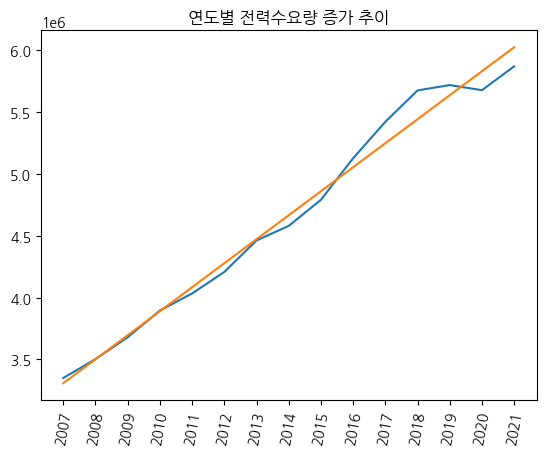

In [23]:
import koreanize_matplotlib
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df_year[["year"]], df_year["sum"])
pred = model.predict(df_year[["year"]])
plt.plot(df_year["year"], df_year["sum"])
plt.plot(df_year["year"], pred)
plt.xticks(rotation=80)
plt.title("연도별 전력수요량 증가 추이")
plt.show()


In [33]:
df=pd.read_csv("./data/03_에너지 사용량.csv")

In [34]:
df

,연도,월,전기 사용량(kWh)
0,2013,1,341532
1,2013,2,315702
2,2013,3,258552
3,2013,4,222462
4,2013,5,184683
...,...,...,...
129,2023,10,190552
130,2023,11,216338
131,2023,12,281571
132,2024,1,314334


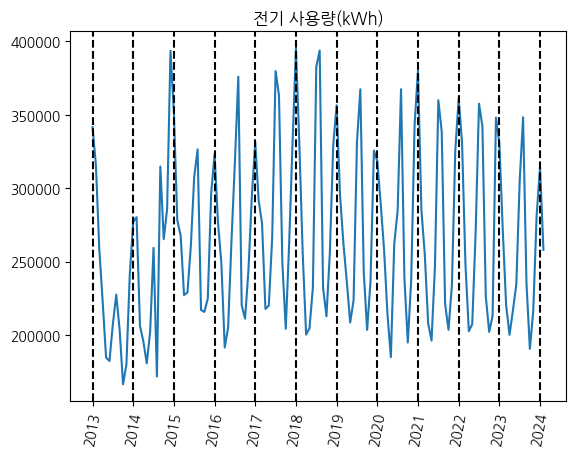

In [36]:
plt.plot(df["전기 사용량(kWh)"])
plt.title("전기 사용량(kWh)")
plt.xticks(range(0,len(df), 12), labels=[i for i in range(2013, 2025)] ,rotation=80)
# 12개마다 년도 표시하기
for i in range(0, len(df), 12):
    plt.axvline(x=i, color="black", linestyle="--")

In [37]:
# 연도별 최대전력 뽑기
df_year = df.groupby("연도").sum()
df_year = df_year.reset_index()
df_year = df_year[["연도", "전기 사용량(kWh)"]]

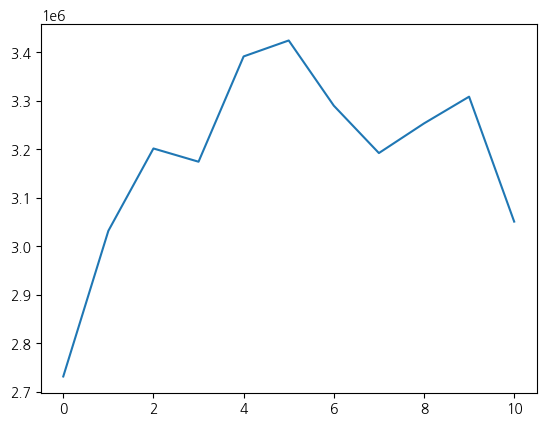

In [41]:
plt.plot(df_year["전기 사용량(kWh)"][:-1])

In [ ]:
# 결론
# https://www.yna.co.kr/view/AKR20230304039100003#:~:text=%28%EC%84%9C%EC%9A%B8%3D%EC%97%B0%ED%95%A9%EB%89%B4%EC%8A%A4%29%20%EA%B6%8C%ED%9D%AC%EC%9B%90%20%EA%B8%B0%EC%9E%90%20%3D%20%EC%A0%84%EB%A0%A5%20%EC%88%98%EC%9A%94%EA%B0%80%20%EC%98%AC%ED%95%B4%20%EB%93%A4%EC%96%B4,%28%EB%A9%94%EA%B0%80%EC%99%80%ED%8A%B8%29%EB%A1%9C%20%EC%9E%91%EB%85%84%20%EA%B0%99%EC%9D%80%20%EB%8B%AC%20%287%EB%A7%8C7%EC%B2%9C278MW%29%20%EB%8C%80%EB%B9%84%201.4%25%20%EA%B0%90%EC%86%8C%ED%96%88%EB%8B%A4.
# 전기요금 인상, 기온 변화 
# https://www.yna.co.kr/view/AKR20240222122600003
# 한국 전기차 판매 4% 감소 : 세액공제, 배터리 가격 경쟁력 및 안정성 개선
# 결국, R&D 와 시설투자에 대한 지원확대를 통해 전동화 경쟁력을 보강해야 한다 
# https://www.wowtv.co.kr/NewsCenter/News/Read?articleId=A202404090070&t=NN
# -> 구리 가격은 1년 새 최고치 기록(전선 제조 원가의 90%차지) -> AI 산업 확장에 따라 데이터센터 설립이 늘어나고, 전기차 충전 인프라 확충으로 인해 전선 및 전력주 상승이 이어짐
# -> 전력수요 증가에 따른 전력공급 확충 필요
# https://view.asiae.co.kr/article/2024040816052856654
# -> 의외의 결과, AI와 연관된 기사가 나온다
# 신재생 에너지에 대한 관심이 높아짐
